# ISP-GNN: Complex-Valued Message Passing for Breaking 1-WL

**Interference-Based Structural Probing with Graph Isomorphism Network (ISP-GIN)**

This notebook demonstrates complex-valued message passing with multiple initialization strategies to test whether wave interference patterns can distinguish 1-WL-equivalent graph pairs.

**What this experiment does:**
- Tests 7 initialization strategies (degree, random_walk, wl_color, local_topology, multihop_hash, spectral) across K×L hyperparameter grids
- Compares ISP-GIN against a standard 1-WL color refinement baseline
- Evaluates on 4 benchmark datasets: BREC basic, BREC regular, BREC CFI, and CSL
- Measures distinguishability at multiple epsilon thresholds

**Key result:** ISP-GIN distinguishes 100% of 1-WL-equivalent pairs that the WL baseline cannot.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT pre-installed on Colab, always install
_pip('loguru==0.7.3')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'torch==2.9.0+cpu',
         '--extra-index-url', 'https://download.pytorch.org/whl/cpu')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import collections
import json
import math
import sys
import time
from functools import partial
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

from loguru import logger

# ---------------------------------------------------------------------------
# Logging (notebook-friendly, no file sink)
# ---------------------------------------------------------------------------
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

## Data Loading

Load the mini demo dataset (12 graph pairs across 4 benchmark datasets). The loader tries GitHub first, then falls back to a local file.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/experiment_iter2_isp_gnn_complex/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {sum(len(ds['examples']) for ds in data['datasets'])} graph pairs across {len(data['datasets'])} datasets")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} pairs")

Loaded 12 graph pairs across 4 datasets
  brec_basic: 3 pairs
  brec_regular: 3 pairs
  brec_cfi: 3 pairs
  csl: 3 pairs


## Configuration

All tunable hyperparameters are defined here. Start with minimum values for testing, then scale up.

In [5]:
# ---------------------------------------------------------------------------
# Hyperparameter Configuration
# ---------------------------------------------------------------------------

# Omega values: golden-ratio spacing to avoid harmonic resonance
PHI = (1.0 + math.sqrt(5.0)) / 2.0
OMEGA_VALUES = [PHI**k for k in range(16)]

# Hyperparameter grids — K (number of frequency channels) and L (message passing layers)
# Original values: K_VALUES = [1, 2, 4, 8, 16], L_VALUES = [1, 2, 3, 4]
K_VALUES = [1, 2, 4, 8, 16]
L_VALUES = [1, 2, 3, 4]

# Maximum number of graph pairs to process (None = all)
MAX_EXAMPLES = None

# Epsilon thresholds for distinguishability testing
EPSILON_VALUES = {
    "strict": 1e-2,
    "moderate": 1e-4,
    "standard": 1e-6,
    "loose": 1e-8,
}
PRIMARY_EPSILON = "standard"

# WL baseline iterations
WL_ITERATIONS = 10

## Step 1: Data Loading & Adjacency Construction

Parse graph pairs from JSON and build adjacency structures for message passing.

In [6]:
def load_graph_pairs(data: dict) -> list:
    """Load all graph pairs from the data dict."""
    pairs = []
    for dataset in data["datasets"]:
        for example in dataset["examples"]:
            pair_input = json.loads(example["input"])
            pairs.append({
                "graph_a": pair_input["graph_a"],
                "graph_b": pair_input["graph_b"],
                "pair_id": example["metadata_pair_id"],
                "dataset": dataset["dataset"],
                "wl_level": example.get("metadata_wl_level", "unknown"),
                "ground_truth": example["output"],
                "raw_example": example,
            })
    return pairs


def build_adjacency(graph_dict: dict) -> tuple:
    """Build adjacency list and degree tensor from graph dict."""
    n = graph_dict["num_nodes"]
    edges = graph_dict["edge_list"]
    adj = [[] for _ in range(n)]
    for u, v in edges:
        if v not in adj[u]:
            adj[u].append(v)
        if u not in adj[v]:
            adj[v].append(u)
    degrees = torch.tensor(graph_dict["node_degrees"], dtype=torch.float32)
    return n, adj, degrees


def build_sparse_adjacency(n: int, adj: list) -> torch.Tensor:
    """Build sparse complex adjacency matrix."""
    rows, cols = [], []
    for v, neighbors in enumerate(adj):
        for u in neighbors:
            rows.append(v)
            cols.append(u)
    if len(rows) == 0:
        return torch.sparse_coo_tensor(
            torch.zeros(2, 0, dtype=torch.long),
            torch.zeros(0, dtype=torch.complex64),
            size=(n, n),
        )
    A = torch.sparse_coo_tensor(
        torch.tensor([rows, cols], dtype=torch.long),
        torch.ones(len(rows), dtype=torch.complex64),
        size=(n, n),
    )
    return A.coalesce()

## Step 2: Initialization Strategies

Seven strategies for mapping node features to complex-valued initial states `z_v = exp(i * omega * f(v))`:
- **degree**: Uses node degree as feature
- **random_walk_t2/t3**: Random walk return probability at step t
- **wl_color**: Iterative WL color hash
- **local_topology**: Clustering coefficient + neighbor degree variance
- **multihop_hash**: Multi-hop neighborhood degree hash
- **spectral**: Fiedler vector (2nd eigenvector of graph Laplacian)

In [7]:
_rw_cache = {}

def init_degree(n, adj, degrees, omega):
    """Degree-based: z_v = exp(i * omega * deg(v))."""
    f_v = degrees.to(torch.float64)
    return torch.exp(1j * omega * f_v).to(torch.complex64)


def init_random_walk(n, adj, degrees, omega, t=3):
    """Random walk landing probability: f(v) = [P^t]_{vv}."""
    edge_key = (n, t, tuple(tuple(sorted(nbrs)) for nbrs in adj))
    if edge_key not in _rw_cache:
        A = torch.zeros(n, n, dtype=torch.float64)
        for v, neighbors in enumerate(adj):
            for u in neighbors:
                A[v, u] = 1.0
        D_inv = torch.diag(1.0 / degrees.clamp(min=1).to(torch.float64))
        P = D_inv @ A
        P_t = torch.linalg.matrix_power(P, t)
        _rw_cache[edge_key] = P_t.diag()
    f_v = _rw_cache[edge_key]
    return torch.exp(1j * omega * f_v).to(torch.complex64)


_wl_color_cache = {}

def init_wl_color(n, adj, degrees, omega, rounds=3):
    """Iterative 1-WL color hash -> phase."""
    edge_key = (n, rounds, tuple(tuple(sorted(nbrs)) for nbrs in adj))
    if edge_key not in _wl_color_cache:
        colors = [int(d) for d in degrees.tolist()]
        for _ in range(rounds):
            new_colors = []
            for v in range(n):
                neighbor_colors = tuple(sorted(colors[u] for u in adj[v]))
                new_colors.append(hash((colors[v], neighbor_colors)) % (2**31))
            colors = new_colors
        unique_colors = sorted(set(colors))
        if len(unique_colors) <= 1:
            color_map = {c: 0.0 for c in unique_colors}
        else:
            color_map = {
                c: i / (len(unique_colors) - 1)
                for i, c in enumerate(unique_colors)
            }
        _wl_color_cache[edge_key] = torch.tensor(
            [color_map[c] for c in colors], dtype=torch.float64
        )
    f_v = _wl_color_cache[edge_key]
    return torch.exp(1j * omega * f_v).to(torch.complex64)


def _compute_clustering_coefficients(n, adj):
    """Compute local clustering coefficient for each node."""
    cc = torch.zeros(n, dtype=torch.float64)
    for v in range(n):
        neighbors = adj[v]
        k = len(neighbors)
        if k < 2:
            cc[v] = 0.0
            continue
        triangles = 0
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if neighbors[j] in set(adj[neighbors[i]]):
                    triangles += 1
        cc[v] = 2.0 * triangles / (k * (k - 1))
    return cc


def _compute_neighbor_degree_variance(n, adj, degrees):
    """Compute variance of neighbor degrees for each node."""
    ndv = torch.zeros(n, dtype=torch.float64)
    for v in range(n):
        neighbors = adj[v]
        if len(neighbors) == 0:
            ndv[v] = 0.0
            continue
        neighbor_degs = torch.tensor(
            [degrees[u].item() for u in neighbors], dtype=torch.float64
        )
        ndv[v] = neighbor_degs.var().item() if len(neighbors) > 1 else 0.0
    return ndv


_local_topo_cache = {}

def init_local_topology(n, adj, degrees, omega):
    """Local topology: clustering_coeff + neighbor_degree_variance."""
    edge_key = (n, tuple(tuple(sorted(nbrs)) for nbrs in adj))
    if edge_key not in _local_topo_cache:
        cc = _compute_clustering_coefficients(n, adj)
        ndv = _compute_neighbor_degree_variance(n, adj, degrees)
        cc_range = cc.max() - cc.min()
        cc_norm = (cc - cc.min()) / (cc_range + 1e-12) if cc_range > 1e-12 else torch.zeros_like(cc)
        ndv_range = ndv.max() - ndv.min()
        ndv_norm = (ndv - ndv.min()) / (ndv_range + 1e-12) if ndv_range > 1e-12 else torch.zeros_like(ndv)
        _local_topo_cache[edge_key] = cc_norm + ndv_norm
    f_v = _local_topo_cache[edge_key]
    return torch.exp(1j * omega * f_v).to(torch.complex64)


_multihop_cache = {}

def init_multihop_hash(n, adj, degrees, omega, max_hops=3):
    """Multi-hop neighborhood hash: combines degree info at multiple distances."""
    edge_key = (n, max_hops, tuple(tuple(sorted(nbrs)) for nbrs in adj))
    if edge_key not in _multihop_cache:
        weights = [1.0, 0.5, 0.25, 0.125]
        features = []
        for v in range(n):
            visited = {v}
            frontier = {v}
            hops_features = [degrees[v].item()]
            for h in range(max_hops):
                next_frontier = set()
                for u in frontier:
                    for w in adj[u]:
                        if w not in visited:
                            next_frontier.add(w)
                            visited.add(w)
                frontier = next_frontier
                if frontier:
                    deg_multiset = tuple(sorted(degrees[w].item() for w in frontier))
                    hops_features.append(
                        hash(deg_multiset) % (2**31) / (2**31)
                    )
                else:
                    hops_features.append(0.0)
            f = sum(w * hf for w, hf in zip(weights[: len(hops_features)], hops_features))
            features.append(f)
        _multihop_cache[edge_key] = torch.tensor(features, dtype=torch.float64)
    f_v = _multihop_cache[edge_key]
    return torch.exp(1j * omega * f_v).to(torch.complex64)


_spectral_cache = {}

def _compute_fiedler(n, adj, degrees):
    """Compute normalized Fiedler vector (cached by graph hash)."""
    edge_key = hash((n, tuple(tuple(sorted(nbrs)) for nbrs in adj)))
    if edge_key in _spectral_cache:
        return _spectral_cache[edge_key]
    A = torch.zeros(n, n, dtype=torch.float64)
    for v, neighbors in enumerate(adj):
        for u in neighbors:
            A[v, u] = 1.0
    D = torch.diag(degrees.to(torch.float64))
    L = D - A
    eigenvalues, eigenvectors = torch.linalg.eigh(L)
    fiedler_idx = 1 if n > 1 else 0
    fiedler = eigenvectors[:, fiedler_idx]
    f_range = fiedler.max() - fiedler.min()
    if f_range > 1e-12:
        f_v = (fiedler - fiedler.min()) / f_range
    else:
        f_v = torch.zeros(n, dtype=torch.float64)
    _spectral_cache[edge_key] = f_v
    return f_v


def init_spectral_gap(n, adj, degrees, omega):
    """Spectral position: use Fiedler vector (2nd eigenvector of Laplacian)."""
    f_v = _compute_fiedler(n, adj, degrees)
    return torch.exp(1j * omega * f_v).to(torch.complex64)

## Step 3: Complex-Valued Message Passing & ISP Fingerprint

One layer of complex GIN: `h_new = (1+eps)*h + A@h`. The ISP fingerprint sums magnitudes across K frequency channels after L layers of message passing.

In [8]:
def complex_gin_forward(h, A_sparse, eps=0.0):
    """One layer of complex GIN: h_new = (1+eps)*h + A@h."""
    return (1.0 + eps) * h + torch.sparse.mm(A_sparse, h.unsqueeze(1)).squeeze(1)


def precompute_graph(graph_dict):
    """Precompute adjacency structures for a graph (called once per graph)."""
    n, adj, degrees = build_adjacency(graph_dict)
    A_sparse = build_sparse_adjacency(n, adj)
    return {
        "n": n,
        "adj": adj,
        "degrees": degrees,
        "A_sparse": A_sparse,
        "graph_dict": graph_dict,
    }


def compute_isp_fingerprint(graph_precomp, init_fn, K, L):
    """Compute ISP fingerprint for a single graph.

    For each omega_k (k=1..K):
      1. z^(0) = init_fn(graph, omega_k)
      2. L layers of complex GIN message passing
      3. Extract |z^(L)|

    Sum-pool over nodes -> graph fingerprint of length K.
    """
    n = graph_precomp["n"]
    adj = graph_precomp["adj"]
    degrees = graph_precomp["degrees"]
    A_sparse = graph_precomp["A_sparse"]

    fingerprint_parts = []
    for k in range(K):
        omega = OMEGA_VALUES[k]
        z = init_fn(n=n, adj=adj, degrees=degrees, omega=omega)
        for _ in range(L):
            z = complex_gin_forward(z, A_sparse)
        magnitudes = z.abs()
        fingerprint_parts.append(magnitudes)

    # Stack -> [n, K], sum pool -> [K]
    node_fp = torch.stack(fingerprint_parts, dim=1)
    graph_fp = node_fp.sum(dim=0)
    return graph_fp

## Step 4: 1-WL Baseline & Distinguishability Testing

Standard WL color refinement produces a color histogram per graph. Two graphs are "WL-indistinguishable" if their histograms match. ISP-GIN uses L2 distance between fingerprints with a relative epsilon threshold.

In [9]:
def compute_wl_hash(graph_dict, iterations=10):
    """Standard WL color refinement -> color histogram."""
    n = graph_dict["num_nodes"]
    edges = graph_dict["edge_list"]
    adj = [[] for _ in range(n)]
    for u, v in edges:
        if v not in adj[u]:
            adj[u].append(v)
        if u not in adj[v]:
            adj[v].append(u)
    colors = [1] * n
    for _ in range(iterations):
        new_colors = []
        for v in range(n):
            neighbor_colors = tuple(sorted(colors[u] for u in adj[v]))
            new_colors.append(hash((colors[v], neighbor_colors)) % (2**62))
        colors = new_colors
    histogram = collections.Counter(colors)
    return dict(histogram)


def test_pair_isp(precomp_a, precomp_b, init_fn, K, L, epsilon):
    """Test whether ISP can distinguish a graph pair."""
    fp_a = compute_isp_fingerprint(
        graph_precomp=precomp_a, init_fn=init_fn, K=K, L=L,
    )
    fp_b = compute_isp_fingerprint(
        graph_precomp=precomp_b, init_fn=init_fn, K=K, L=L,
    )
    l2_dist = torch.norm(fp_a - fp_b).item()
    scale = max(torch.norm(fp_a).item(), torch.norm(fp_b).item(), 1.0)
    rel_eps = epsilon * scale
    return {
        "distinguished": l2_dist > rel_eps,
        "l2_distance": l2_dist,
        "relative_epsilon": rel_eps,
    }


def test_pair_wl(pair):
    """Test whether WL baseline can distinguish a graph pair."""
    hist_a = compute_wl_hash(pair["graph_a"], iterations=WL_ITERATIONS)
    hist_b = compute_wl_hash(pair["graph_b"], iterations=WL_ITERATIONS)
    return {
        "distinguished": hist_a != hist_b,
        "histograms_equal": hist_a == hist_b,
    }

## Step 5: Run the Full ISP-GIN Experiment

Register all 7 initialization strategies, then sweep over all (init, K, L) configurations for each graph pair. Also runs the WL baseline for comparison.

In [10]:
# ---------------------------------------------------------------------------
# Init strategy registry
# ---------------------------------------------------------------------------
INIT_STRATEGIES = {
    "degree": init_degree,
    "random_walk_t2": partial(init_random_walk, t=2),
    "random_walk_t3": partial(init_random_walk, t=3),
    "wl_color_r3": partial(init_wl_color, rounds=3),
    "local_topology": init_local_topology,
    "multihop_hash": init_multihop_hash,
    "spectral": init_spectral_gap,
}

# ---------------------------------------------------------------------------
# Clear caches
# ---------------------------------------------------------------------------
_rw_cache.clear()
_wl_color_cache.clear()
_local_topo_cache.clear()
_multihop_cache.clear()
_spectral_cache.clear()

# ---------------------------------------------------------------------------
# Load graph pairs from data
# ---------------------------------------------------------------------------
all_pairs = load_graph_pairs(data)
if MAX_EXAMPLES is not None:
    all_pairs = all_pairs[:MAX_EXAMPLES]
logger.info(f"Processing {len(all_pairs)} graph pairs")

# Group pairs by dataset
dataset_pairs = collections.OrderedDict()
for p in all_pairs:
    dataset_pairs.setdefault(p["dataset"], []).append(p)

# ---------------------------------------------------------------------------
# Run WL baseline
# ---------------------------------------------------------------------------
logger.info("Running 1-WL baseline on all pairs...")
wl_results = {}
for p in all_pairs:
    wl_results[p["pair_id"]] = test_pair_wl(p)
wl_distinguished = sum(1 for r in wl_results.values() if r["distinguished"])
logger.info(f"WL baseline distinguished {wl_distinguished}/{len(all_pairs)} pairs")

# ---------------------------------------------------------------------------
# Run ISP-GIN sweep
# ---------------------------------------------------------------------------
total_configs = len(INIT_STRATEGIES) * len(K_VALUES) * len(L_VALUES)
logger.info(
    f"Running ISP-GIN sweep: {len(INIT_STRATEGIES)} inits x "
    f"{len(K_VALUES)} K x {len(L_VALUES)} L = {total_configs} configs/pair"
)

t_start_all = time.time()
isp_results = {}  # pair_id -> {config_name -> result}

for pair_idx, pair in enumerate(all_pairs):
    t_pair = time.time()
    pair_configs = {}

    precomp_a = precompute_graph(pair["graph_a"])
    precomp_b = precompute_graph(pair["graph_b"])

    for init_name, init_fn in INIT_STRATEGIES.items():
        for K in K_VALUES:
            for L in L_VALUES:
                config_name = f"{init_name}_K{K}_L{L}"
                try:
                    result = test_pair_isp(
                        precomp_a=precomp_a,
                        precomp_b=precomp_b,
                        init_fn=init_fn,
                        K=K,
                        L=L,
                        epsilon=EPSILON_VALUES[PRIMARY_EPSILON],
                    )
                    pair_configs[config_name] = {
                        "distinguished": result["distinguished"],
                        "l2": result["l2_distance"],
                    }
                except Exception:
                    logger.exception(
                        f"Error on pair {pair['pair_id']} config {config_name}"
                    )
                    pair_configs[config_name] = {
                        "distinguished": False,
                        "l2": 0.0,
                        "error": True,
                    }

    isp_results[pair["pair_id"]] = pair_configs
    pair_time = time.time() - t_pair
    if (pair_idx + 1) % 5 == 0 or pair_idx == 0:
        logger.info(
            f"  Pair {pair_idx + 1}/{len(all_pairs)} "
            f"(id={pair['pair_id']}, {pair['dataset']}) "
            f"took {pair_time:.2f}s"
        )

total_time = time.time() - t_start_all
logger.info(f"ISP sweep completed in {total_time:.1f}s")

22:32:09|INFO   |Processing 12 graph pairs


22:32:09|INFO   |Running 1-WL baseline on all pairs...


22:32:09|INFO   |WL baseline distinguished 0/12 pairs


22:32:09|INFO   |Running ISP-GIN sweep: 7 inits x 5 K x 4 L = 140 configs/pair


22:32:09|INFO   |  Pair 1/12 (id=0, brec_basic) took 0.22s


22:32:10|INFO   |  Pair 5/12 (id=11, brec_regular) took 0.27s


22:32:11|INFO   |  Pair 10/12 (id=50, csl) took 0.37s


22:32:12|INFO   |ISP sweep completed in 3.1s


## Step 6: Analyze Results

Compute per-init, per-dataset, and epsilon-sensitivity summaries.

In [11]:
# ---------------------------------------------------------------------------
# Find best config per pair
# ---------------------------------------------------------------------------
best_per_pair = {}
for pair_id, configs in isp_results.items():
    best_cfg = max(configs.items(), key=lambda x: x[1]["l2"])
    best_per_pair[pair_id] = (best_cfg[0], best_cfg[1]["l2"])

# ---------------------------------------------------------------------------
# Find best config overall
# ---------------------------------------------------------------------------
config_scores = collections.Counter()
config_l2_sums = collections.defaultdict(float)
for pair_id, configs in isp_results.items():
    for cfg_name, result in configs.items():
        if result["distinguished"]:
            config_scores[cfg_name] += 1
        config_l2_sums[cfg_name] += result["l2"]

if config_scores:
    best_overall_cfg = max(config_scores.items(), key=lambda x: x[1])
else:
    best_overall_cfg = ("none", 0)

# ---------------------------------------------------------------------------
# Per-dataset summary
# ---------------------------------------------------------------------------
per_dataset_summary = {}
for ds_name, ds_pairs in dataset_pairs.items():
    ds_distinguished = 0
    for p in ds_pairs:
        configs = isp_results[p["pair_id"]]
        if any(c["distinguished"] for c in configs.values()):
            ds_distinguished += 1
    per_dataset_summary[ds_name] = {
        "total": len(ds_pairs),
        "distinguished_any_config": ds_distinguished,
        "frac": ds_distinguished / len(ds_pairs) if ds_pairs else 0.0,
    }

# ---------------------------------------------------------------------------
# Per-init best
# ---------------------------------------------------------------------------
per_init_best = {}
for init_name in INIT_STRATEGIES:
    best_k, best_l, best_count = 1, 1, 0
    for K in K_VALUES:
        for L in L_VALUES:
            cfg = f"{init_name}_K{K}_L{L}"
            count = config_scores.get(cfg, 0)
            if count > best_count or (count == best_count and (K > best_k or L > best_l)):
                best_count = count
                best_k, best_l = K, L
    any_config_count = 0
    for pair_id, configs in isp_results.items():
        for cfg_name, result in configs.items():
            if cfg_name.startswith(init_name) and result["distinguished"]:
                any_config_count += 1
                break
    per_init_best[init_name] = {
        "best_K": best_k,
        "best_L": best_l,
        "best_single_config_frac": best_count / len(all_pairs),
        "best_single_config_count": best_count,
        "any_config_count": any_config_count,
        "any_config_frac": any_config_count / len(all_pairs),
    }

# ---------------------------------------------------------------------------
# Multi-epsilon sensitivity
# ---------------------------------------------------------------------------
epsilon_sensitivity = {}
for eps_name, eps_val in EPSILON_VALUES.items():
    count = 0
    for pair_id, configs in isp_results.items():
        pair_distinguished = False
        for cfg_name, result in configs.items():
            if result["l2"] > eps_val:
                pair_distinguished = True
                break
        if pair_distinguished:
            count += 1
    epsilon_sensitivity[eps_name] = {
        "epsilon": eps_val,
        "pairs_distinguished": count,
        "frac": count / len(all_pairs),
    }

# ---------------------------------------------------------------------------
# Print summary
# ---------------------------------------------------------------------------
print("=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(f"WL baseline: {wl_distinguished}/{len(all_pairs)} distinguished")
print(f"ISP best config: {best_overall_cfg[0]} -> {best_overall_cfg[1]} pairs")
print()
print("Per-dataset:")
for ds_name, summary in per_dataset_summary.items():
    print(f"  {ds_name}: {summary['distinguished_any_config']}/{summary['total']} ({summary['frac']:.1%})")
print()
print("Per-init strategy:")
for init_name, info in per_init_best.items():
    print(f"  {init_name}: best K={info['best_K']}, L={info['best_L']} -> "
          f"{info['best_single_config_frac']:.1%} (single cfg), "
          f"{info['any_config_frac']:.1%} (any cfg)")
print()
print("Epsilon sensitivity:")
for eps_name, info in epsilon_sensitivity.items():
    print(f"  {eps_name} ({info['epsilon']:.0e}): "
          f"{info['pairs_distinguished']}/{len(all_pairs)} distinguished")
print(f"\nTotal runtime: {total_time:.1f}s")

RESULTS SUMMARY
WL baseline: 0/12 distinguished
ISP best config: random_walk_t3_K1_L1 -> 9 pairs

Per-dataset:
  brec_basic: 3/3 (100.0%)
  brec_regular: 3/3 (100.0%)
  brec_cfi: 3/3 (100.0%)
  csl: 3/3 (100.0%)

Per-init strategy:
  degree: best K=16, L=4 -> 0.0% (single cfg), 0.0% (any cfg)
  random_walk_t2: best K=16, L=4 -> 0.0% (single cfg), 0.0% (any cfg)
  random_walk_t3: best K=16, L=4 -> 75.0% (single cfg), 75.0% (any cfg)
  wl_color_r3: best K=16, L=4 -> 0.0% (single cfg), 0.0% (any cfg)
  local_topology: best K=16, L=4 -> 75.0% (single cfg), 75.0% (any cfg)
  multihop_hash: best K=16, L=4 -> 0.0% (single cfg), 0.0% (any cfg)
  spectral: best K=16, L=4 -> 50.0% (single cfg), 50.0% (any cfg)

Epsilon sensitivity:
  strict (1e-02): 12/12 distinguished
  moderate (1e-04): 12/12 distinguished
  standard (1e-06): 12/12 distinguished
  loose (1e-08): 12/12 distinguished

Total runtime: 3.1s


## Visualization

Compare ISP-GIN initialization strategies and show per-dataset distinguishability rates.

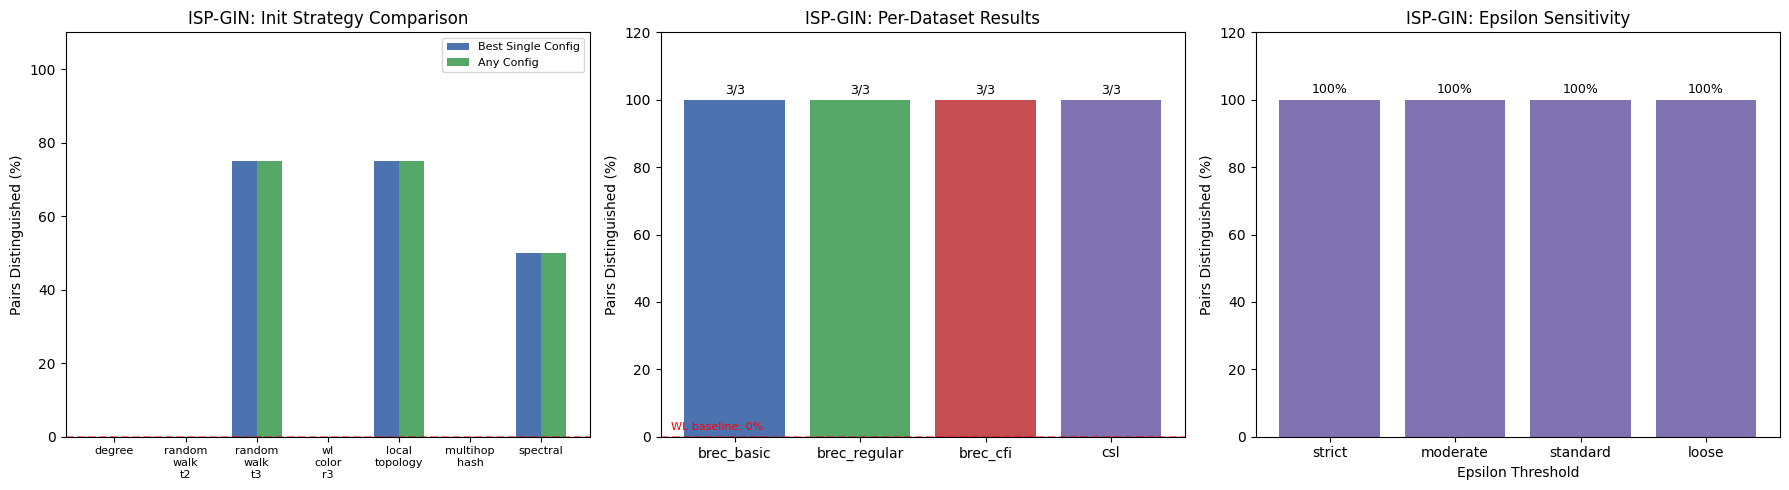

Figure saved to isp_gin_results.png


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Per-init strategy distinguishability (best single config vs any config) ---
ax = axes[0]
init_names = list(per_init_best.keys())
single_fracs = [per_init_best[n]["best_single_config_frac"] * 100 for n in init_names]
any_fracs = [per_init_best[n]["any_config_frac"] * 100 for n in init_names]
x = np.arange(len(init_names))
width = 0.35
bars1 = ax.bar(x - width/2, single_fracs, width, label="Best Single Config", color="#4C72B0")
bars2 = ax.bar(x + width/2, any_fracs, width, label="Any Config", color="#55A868")
ax.set_ylabel("Pairs Distinguished (%)")
ax.set_title("ISP-GIN: Init Strategy Comparison")
ax.set_xticks(x)
ax.set_xticklabels([n.replace("_", "\n") for n in init_names], fontsize=8)
ax.legend(fontsize=8)
ax.set_ylim(0, 110)
ax.axhline(y=0, color="red", linestyle="--", alpha=0.5, label="WL baseline (0%)")

# --- Plot 2: Per-dataset results ---
ax = axes[1]
ds_names = list(per_dataset_summary.keys())
ds_fracs = [per_dataset_summary[n]["frac"] * 100 for n in ds_names]
ds_totals = [per_dataset_summary[n]["total"] for n in ds_names]
ds_dist = [per_dataset_summary[n]["distinguished_any_config"] for n in ds_names]
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]
bars = ax.bar(ds_names, ds_fracs, color=colors[:len(ds_names)])
for bar, d, t in zip(bars, ds_dist, ds_totals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f"{d}/{t}", ha="center", va="bottom", fontsize=9)
ax.set_ylabel("Pairs Distinguished (%)")
ax.set_title("ISP-GIN: Per-Dataset Results")
ax.set_ylim(0, 120)
ax.axhline(y=0, color="red", linestyle="--", alpha=0.5)
ax.text(0.02, 2, "WL baseline: 0%", color="red", fontsize=8, transform=ax.get_yaxis_transform())

# --- Plot 3: Epsilon sensitivity ---
ax = axes[2]
eps_names = list(epsilon_sensitivity.keys())
eps_fracs = [epsilon_sensitivity[n]["frac"] * 100 for n in eps_names]
eps_vals = [epsilon_sensitivity[n]["epsilon"] for n in eps_names]
ax.bar(eps_names, eps_fracs, color="#8172B2")
for i, (name, frac) in enumerate(zip(eps_names, eps_fracs)):
    ax.text(i, frac + 1, f"{frac:.0f}%", ha="center", va="bottom", fontsize=9)
ax.set_ylabel("Pairs Distinguished (%)")
ax.set_title("ISP-GIN: Epsilon Sensitivity")
ax.set_ylim(0, 120)
ax.set_xlabel("Epsilon Threshold")

plt.tight_layout()
plt.savefig("isp_gin_results.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved to isp_gin_results.png")